# *Introduction*

Customer churn, the phenomenon where customers stop using a company's products or services, is a critical metric for businesses across industries. High churn rates directly impact revenue, increase acquisition costs, and reduce long-term profitability. 

Accurately predicting which customers are likely to leave enables companies to implement targeted retention strategies, optimize marketing efforts, and maintain a loyal customer base.

This notebook presents a complete machine learning workflow to predict customer churn using the Telco Customer Churn Dataset. The objective is to build and evaluate 3 models (Random Forest, XGBoost and Light GBM) capable of identifying customers at risk of leaving, allowing the business to proactively retain them and improve overall customer lifetime value.

The current version includes:
* Exploratory Data Analysis (EDA)
* Data Cleaning and preprocessing
* Training baseline models
* Manual and automated hyperparameter tuning
* Final evaluation and insights


# *Table of Contents*



1. Import Libraries  
2. Dataset Overview  
3. Exploratory Data Analysis (EDA)  
4. Data Cleaning and Preprocessing  
5. Feature Engineering and SMOTE
6. Modeling and Evaluation

    A. Baseline Models
     
    B. RandomizedSearchCV and GridSearchCV Tuning RF
   
    C. RandomizedSearchCV and GridSearchCV Tuning XGBoost
   
    D. RandomizedSearchCV and GridSearchCV Tuning LightGBM
   
8. Final Comparative and conclusions
   
9. Future Improvements



# *1.- Import Libraries*

In [7]:
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1
!pip install numpy pandas seaborn matplotlib xgboost lightgbm 

  Using cached scikit-learn-1.2.2.tar.gz (7.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): still running...
  Preparing metadata (pyproject.toml): still running...
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  Preparing metadata (pyproject.toml) did not run successfully.
  exit code: 1
  
  [2402 lines of output]
  Partial import of sklearn during the build process.
  test_program.c
  Generating code
  Finished generating code
  test_program.c
  LINK : warning LNK4044: unrecognized option '/openmp'; ignored
  Generating code
  Finished generating code
  
  Error compiling Cython file:
  ------------------------------------------------------------
  ...
      # particularly tiny on Windows/MSVC.
      # It corresponds to the maximum representable value for
      # 32-bit signed integers (i.e. 2^31 - 1).
      RAND_R_MAX = 0x7FFFFFFF
  
  cpdef sample_without_replacement(cnp.int_t n_population,
                                   ^
  ------------------------------------------------------------
  
  sklearn\utils\_random.pxd:19:33: 'int_t' is not a type identifier
  
  Error compiling Cython file:
  ------------------------------------------------------

In [8]:
#Libraries
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
accuracy_score, confusion_matrix, classification_report, 
roc_curve, auc, precision_recall_curve
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# *2.- Overview of the Dataset*

In [9]:
#Add data
df_raw = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


The dataset contains information about customers of a telecommunications company, including demographic details, account information, services subscribed, and whether the customer has churned (left the company).

Each row represents a customer.

Let´s analyze each column from the dataset:

* **Gender**: Whether the customer is male or female

* **Senior Citizen**: Indicates if the customer is a senior (1) or not (0)

  
* **Partner** and **Dependents**: Are binary features that show family status.

  
* **tenure**: Number of months  the customer has stayed with the company.

  
* **Phone Service** and **Internet Service**: Are the types of services used.

  
* **Contract** and **Payment Method**: Subscription information and billing preferences.

  
* **Monthly Charges** and **Total Charges**: Financial Variables.

  
* **Churn**: Target variable indicating whether the customer left.

# *3.- Exploratory Data Analysis (EDA)*

Let´s start by checking for missing values and columns with only one unique value.

**Null or missing values** Can cause errors or unexpected behavior in many machine learning models, so it's important to identify and handle them appropriately (either by removing or imputing them) 

In [10]:
#Check for missing values in the dataset
df_cleaned = df_raw.copy()
df_cleaned.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

**Columns with only one unique value** do not provide any useful information to the model, since they offer no variability or predictive power.

In [11]:
#Check for columns with only one unique value
for col in df_cleaned.columns:
    if len(df_cleaned[col].unique())==1:
        print(f"{col}has only one unique value:{df_cleaned[col].unique()}")

Now eliminate columns that do not provide any useful information and analyze the type of each column and see if it´s correct.

In [12]:
#Eliminate the column Customer ID
df_cleaned=df_cleaned.drop(columns=["customerID"], axis = 1)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In the dataset, the "Total Charges" column has some empty strings ("") that should be treated as missing values. These entries prevent the column from being recognized as numeric.
In this step: 
- We replace those empty strings with "Nan".
- Convert the column to "float"
- Fill the missing values using the median of the column.
This ensures that "Total Charges" can be used properly in our models.

In [13]:
#Replace empty spaces by NaN
df_cleaned["TotalCharges"]= df_cleaned["TotalCharges"].replace(" ",np.nan)
#Convert column to a float
df_cleaned["TotalCharges"]= df_cleaned["TotalCharges"].astype(float)
#Fill NaN with the median
df_cleaned["TotalCharges"]= df_cleaned["TotalCharges"].fillna(df_cleaned["TotalCharges"].median())
df_cleaned

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


Now we check how many unique categories each object-type column has. This helps us understand which columns need preprocessing, detect potential issues and decide how to handle them.

In [14]:
#How many categories are in columns with objects
df_cleaned.select_dtypes(include="object").nunique()

gender              2
Partner             2
Dependents          2
PhoneService        2
MultipleLines       3
InternetService     3
OnlineSecurity      3
OnlineBackup        3
DeviceProtection    3
TechSupport         3
StreamingTV         3
StreamingMovies     3
Contract            3
PaperlessBilling    2
PaymentMethod       4
Churn               2
dtype: int64

# *4.- Cleaning and Preprocessing Data*

Now we will convert text values into numeric format so that models can process them.

In [15]:
#Code for transform text to number
bin_cols = ["gender","Partner","Dependents","PhoneService","PaperlessBilling","Churn"]
for col in bin_cols:
    df_cleaned[col]=df_cleaned[col].map({"Yes":1, "No":0, "Male":1, "Female":0})

multi_cols= ["MultipleLines","InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract","PaymentMethod"]
df_cleaned = pd.get_dummies(df_cleaned, columns = multi_cols, drop_first= True)

We identify all columns with boolean values (True/False) and convert them to integers:
1 = True
0 = False
This transformation ensures that all features are in numeric format, which is also required for most machine learning models.

In [16]:
df_cleaned.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,False,False,False,False,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,False,False,False,False,False,True,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,1,...,False,False,False,False,False,False,False,False,False,True
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,True,False,False,False,False,True,False,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,1,...,False,False,False,False,False,False,False,False,True,False


In [17]:
for col in df_cleaned.select_dtypes(include=["bool"]).columns:
    df_cleaned[col]= df_cleaned[col].astype(int)

df_cleaned

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,0,0,0,0,0,1,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,84.80,1990.50,0,...,1,0,1,0,1,1,0,0,0,1
7039,0,0,1,1,72,1,1,103.20,7362.90,0,...,0,0,1,0,1,1,0,1,0,0
7040,0,0,1,1,11,0,1,29.60,346.45,0,...,0,0,0,0,0,0,0,0,1,0
7041,1,1,1,0,4,1,1,74.40,306.60,1,...,0,0,0,0,0,0,0,0,0,1


For last we just make sure that the information of the data frame is correct

In [18]:
#Information of the data frame
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7043 non-null   int64  
 1   SeniorCitizen                          7043 non-null   int64  
 2   Partner                                7043 non-null   int64  
 3   Dependents                             7043 non-null   int64  
 4   tenure                                 7043 non-null   int64  
 5   PhoneService                           7043 non-null   int64  
 6   PaperlessBilling                       7043 non-null   int64  
 7   MonthlyCharges                         7043 non-null   float64
 8   TotalCharges                           7043 non-null   float64
 9   Churn                                  7043 non-null   int64  
 10  MultipleLines_No phone service         7043 non-null   int64  
 11  Mult

***Distribution of numerical variables***

Now we are going to explore the distribution of key numerical features in our dataset: "tenure", "MonthlyCharges" and "TotalCharges".

These histograms, combined with a kernel density estimate (KDE), will help us understand the data distribution, detect skewness, and identify potential outliers before modeling.

This step is essential to guide feature engineering and preprocessing decisions.

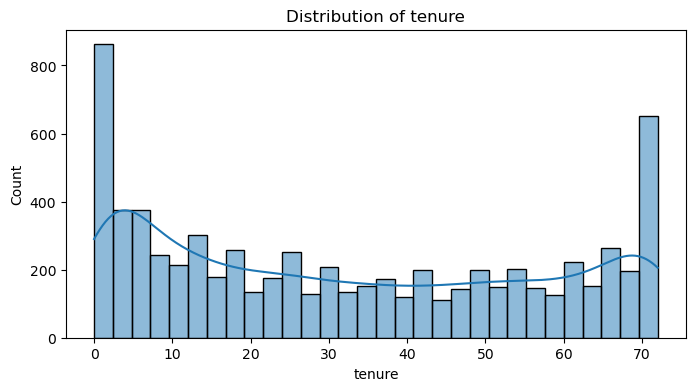

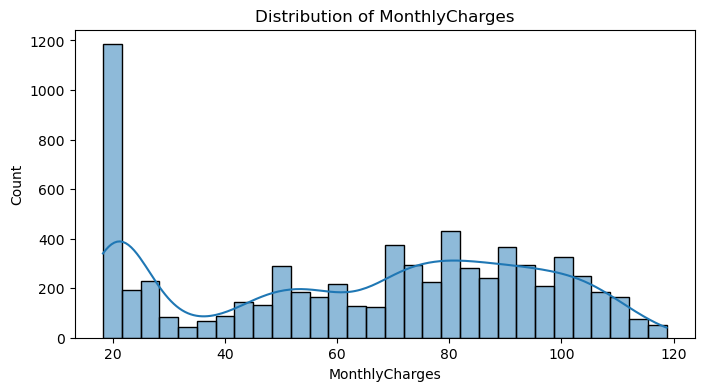

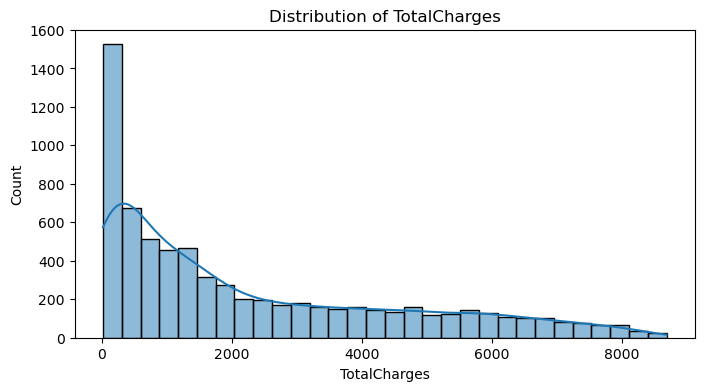

In [19]:
num_cols= ["tenure","MonthlyCharges","TotalCharges"]
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df_cleaned[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

Observing the distributions:

1. **Tenure**: The distribution is bimodal, with many customers at the start (0–1 months) and at the maximum tenure (~72 months). 
   This suggests a group of new customers and another group of long-term customers, which could be relevant for predicting churn.

2. **MonthlyCharges**: Most customers have monthly charges clustered around lower values, with a long tail toward higher charges. 
   This right-skewed distribution indicates that a small number of customers pay significantly higher monthly fees.

3. **TotalCharges**: The distribution is heavily right-skewed, as expected, since it accumulates monthly charges over the tenure. 
   Customers with short tenure contribute to the peak near zero, while long-term customers contribute to the long tail.

Overall, these distributions highlight potential preprocessing needs, such as normalization or log transformation, and suggest that tenure and charges may have different predictive powers for churn.

Although the distributions of "tenure", "MonthlyCharges", and "TotalCharges" show swekness and outliers, we will not apply normalization or log transformations in this case. This is because our main models (Random Forest, XGBoost and LightGBM) are tree-based algorithms, which are robust to non-normal distributions and do not require feature scaling.

However, when using models sensitive to feature scaling or distribution shapes, such as Logistic Regression, Support Vector Machines (SVM), K-Nearest Neighbors (KNN), or Neural Networks, it is recommended to apply transformations like normalization, standardization, or log scaling to improve perfomance and convergence.

***Distribution of Churn***

We will now visualize the distribution of the target variable "Churn" to check the class balance.
Understanding whether the dataset is balanced or imbalanced is crucial, as it influences the choice of evaluation metrics and the need for techniques like resampling (oversampling, undersampling) or class weighting during model training.

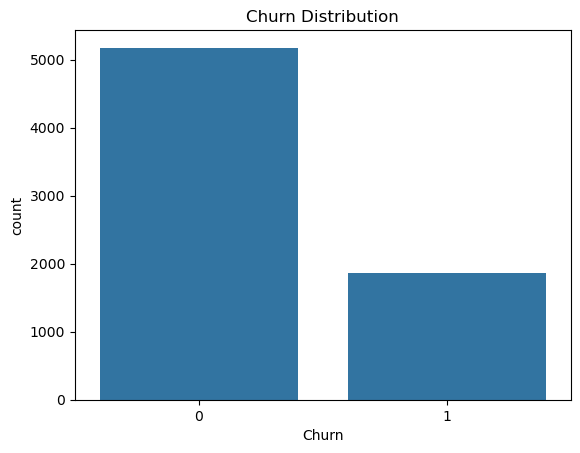

In [20]:
sns.countplot(x="Churn", data=df_cleaned)
plt.title("Churn Distribution")
plt.show()

The *Churn* distribution is highly imbalanced: approximately 5,000 customers did not churn (label 0) compared to about 1,700 customers who did churn (label 1). 
This imbalance means that accuracy alone is not a reliable evaluation metric, as a model could achieve high accuracy by mostly predicting the majority class. 
To address this, we will focus on metrics like recall, precision, and F1-score, and may apply techniques such as oversampling (e.g., SMOTE), undersampling, or class weighting to improve the model's performance on the minority class.

***Relationship between Churn and numerical variables***

Now we will examine the relationship between "Churn" and each numerical feature ("tenure", "MonthlyCharges", and "TotalCharges") using boxplots.

This visualization allows us to compare the distribution of each numerical variable for customers who churned versus those who did not, detect potential differences in central tendency, spread, and the presences of outliers.

Identifying these patterns can provide insights into how these variables may influence customer churn.

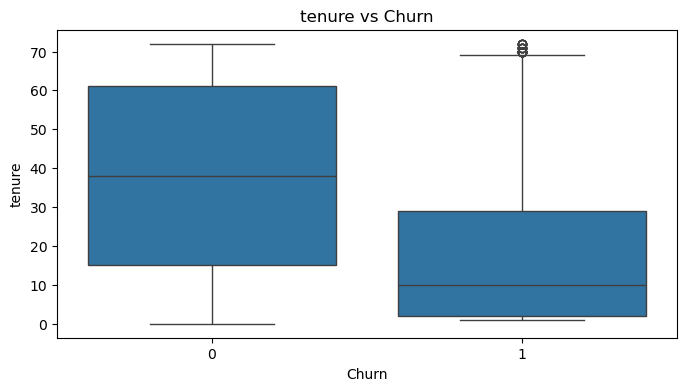

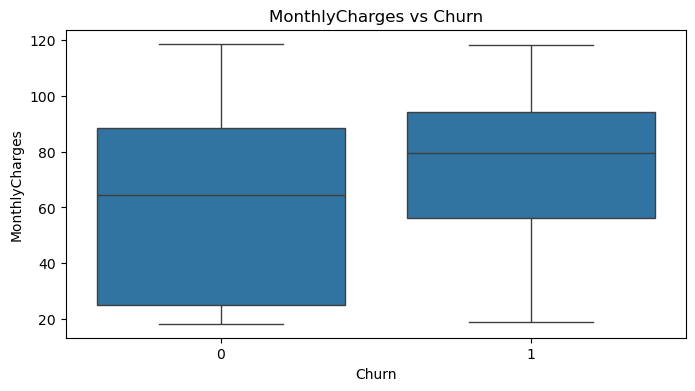

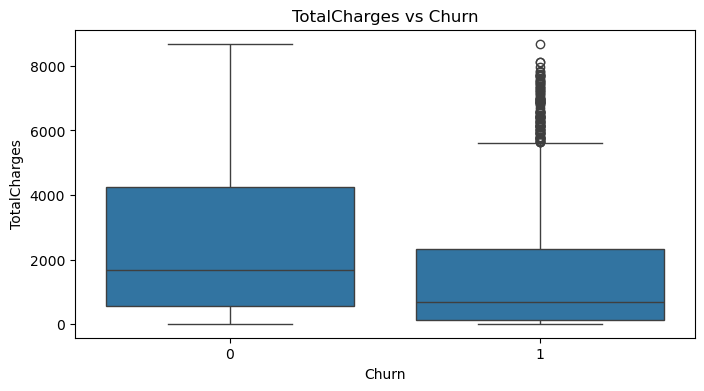

In [21]:
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='Churn', y=col, data=df_cleaned)
    plt.title(f'{col} vs Churn')
    plt.show()

1. **Tenure vs Churn**

- Customers who did not churn tend to have significantly higher tenure values, indicating a longer relationship with the company.
- Customers who churned are more likely to have lower tenure, suggesting that churn is more common early in the customer lifecycle.

2. **Monthly Charges vs Churn**

- Customers who churned tend to have higher monthly charges on average.
- This could indicate that higher monthly prices may contribute to customer dissatisfaction or churn.

3. **Total Charges vs Churn**

- Non-churning customers have higher total charges, which is consistent with their longer tenure.
- Churning customers, despite having higher monthly charges, have lower total charges overall, likely due to their shorter time with the company.

***Relationship between categorical variables and "Churn"***

The goal is to identify whether certain categories within each feature are associated with higher or lower churn rates. Understanding these patterns can help in feature engineering and in interpreting model outputs.

In the code below:

First we create a list called "cat_cols" which contains all categorical columns with 10 or fewer unique values, excluding the target variables "Churn".
Then, for each categorical feature, we plot a countplot grouped by churn status (hue="Churn").
This allows us to visually compare the distribution of churned and non-churned customers across different categories of each variable.

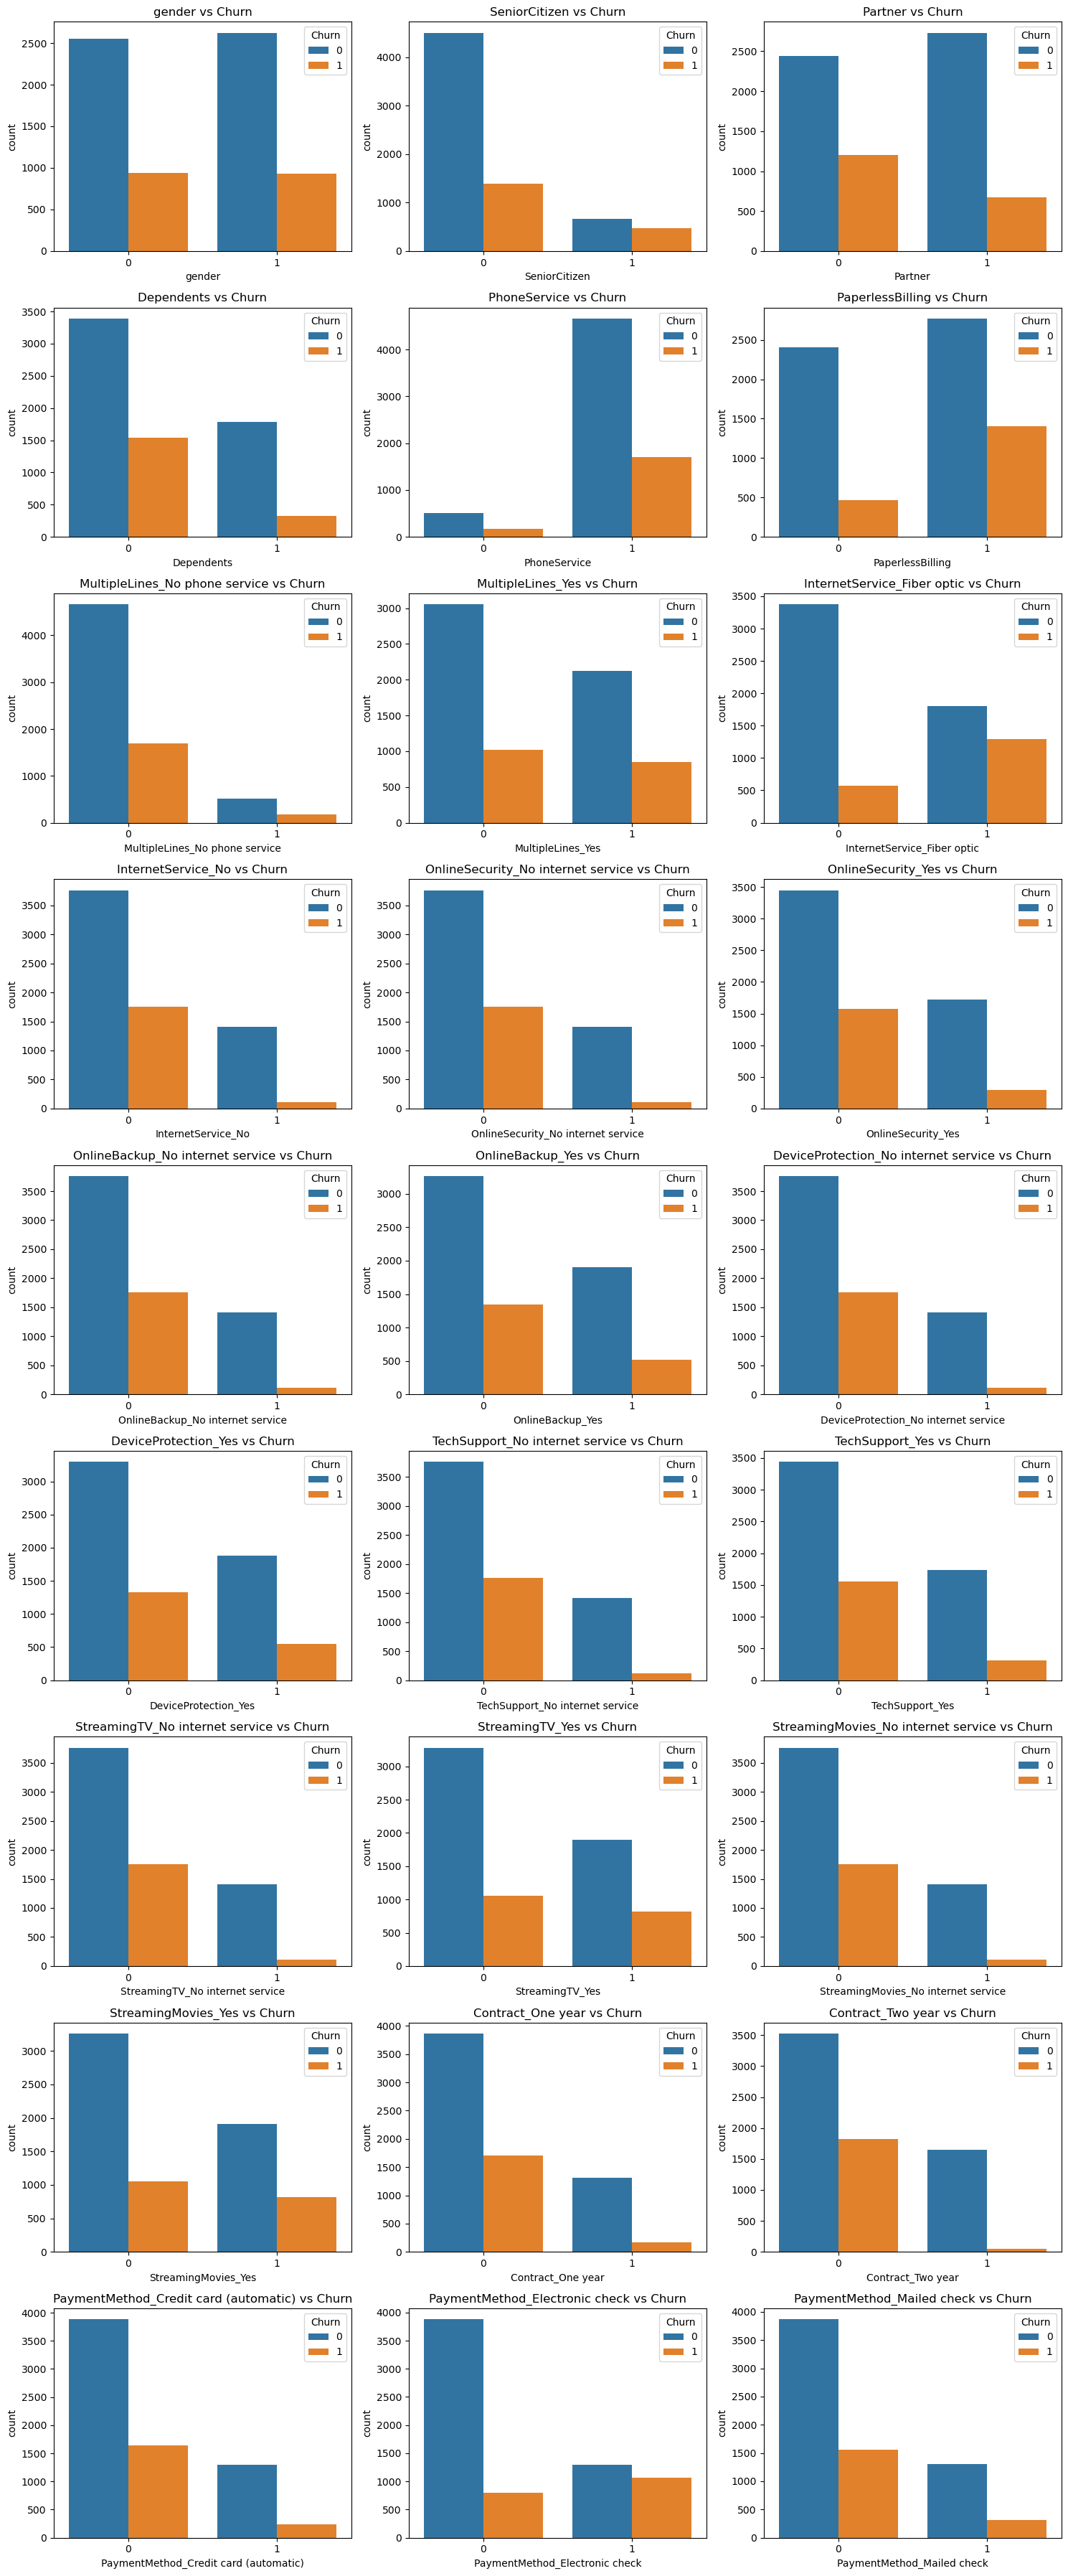

In [22]:

# List of categorical columns
cat_cols = [col for col in df_cleaned.columns if df_cleaned[col].nunique() <= 10 and col != "Churn"]

n_cols = 3  # 3 graphics by row
n_rows = math.ceil(len(cat_cols) / n_cols)

# Create figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()  

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, hue="Churn", data=df_cleaned, ax=axes[i])
    axes[i].set_title(f"{col} vs Churn")

for j in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


The countplots reveal several categorical features with notable differences in churn rates across categories:

- **Contract type:** Shows a strong relationship with churn. Customers with month-to-month contracts have much higher churn rates, while those with one or two year contracts are less likely to churn.
- **Payment method:** Customers paying via eletronic check exhibit significantly higher churn compared to those using credit cards, bank transfers, or mailed checks.
- **Internet Service type and related add-ons:** (Such as OnlineSecurity, TechSupport, and DeviceProtection) also correlate with churn, customers without these services tend to have higher churn.
- **PaperlessBilling:** Is associated with higher churn, possibly because it correlates with other factors like payment method or contract type.
- Demographic variables like **SeniorCitizen, Partne and dependents** show smaller but still visible differences in churn rates.

Overall, these plots indicate that certain service features and payment/contract types are strong predictors of churn, while demographic variables play a second role.

***Correlation of variables with churn***

In this step, we will explore the correlation between all numerical variables in our dataset, including their relationship with the target variable **Churn**.

First, we generate a **correlation matri** using Pearson´s correlation, which measures the linear relationship between variables. The heatmap provides a visual representation, where:
- Values close to **1** indicate a strong positive correlation (variables increase together).
- Values close to **-1** indicate a strong negative correlation (one variable increases while the other decreases).
- Values near **0** indicate little to no linear correlation.

After visualization the full correlation matrix, we specifically extract and sort the correlation values of all features with respect to **Churn**. This helps us identify which numerical features are most strongly related to customer churn, guiding feature selection and model building.

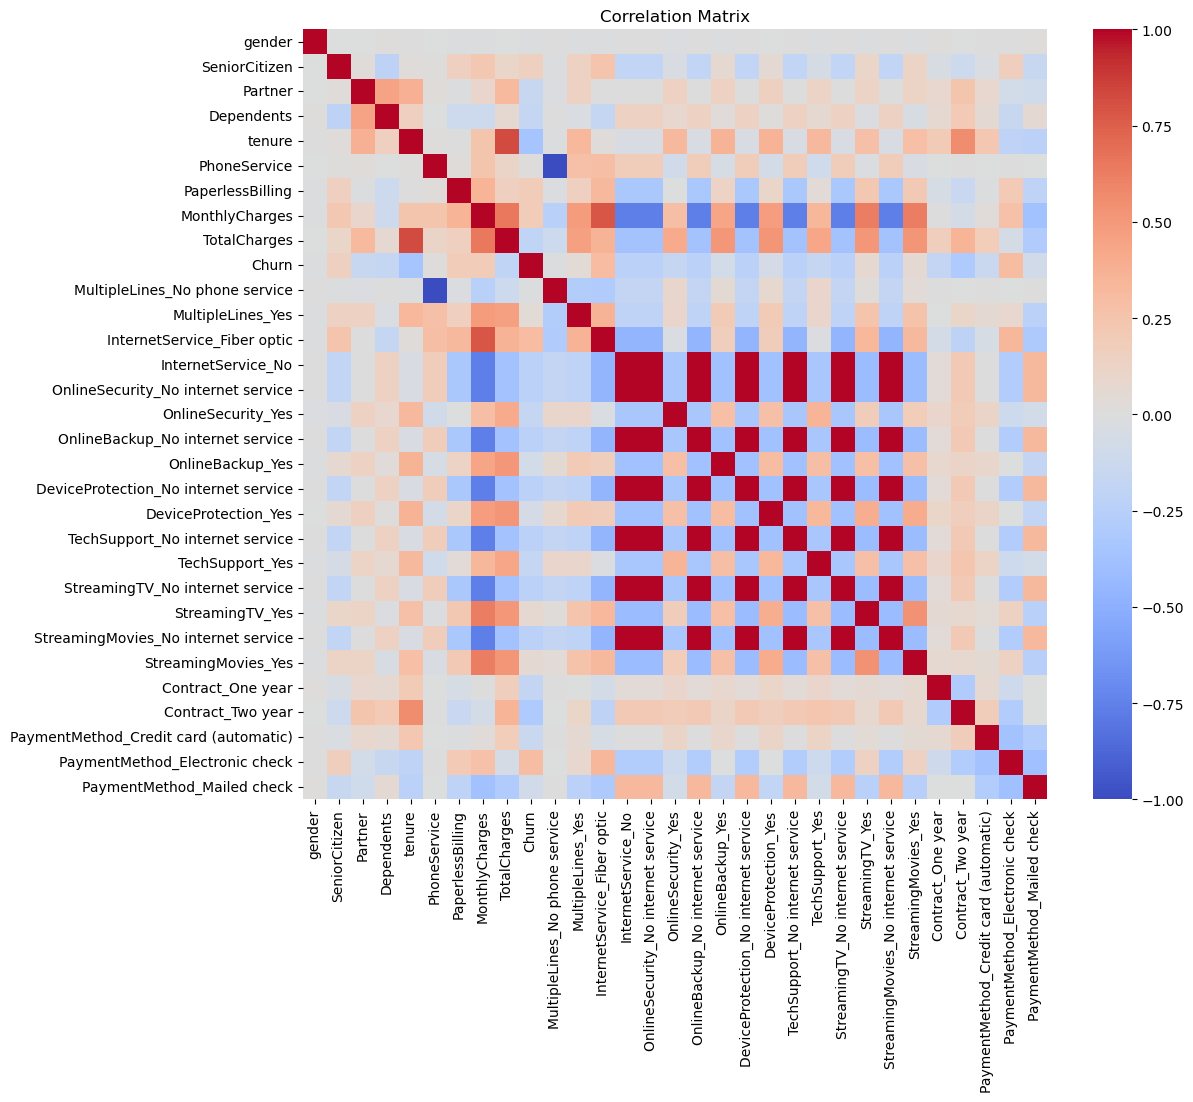

Churn                                    1.000000
InternetService_Fiber optic              0.308020
PaymentMethod_Electronic check           0.301919
MonthlyCharges                           0.193356
PaperlessBilling                         0.191825
SeniorCitizen                            0.150889
StreamingTV_Yes                          0.063228
StreamingMovies_Yes                      0.061382
MultipleLines_Yes                        0.040102
PhoneService                             0.011942
gender                                  -0.008612
MultipleLines_No phone service          -0.011942
DeviceProtection_Yes                    -0.066160
OnlineBackup_Yes                        -0.082255
PaymentMethod_Mailed check              -0.091683
PaymentMethod_Credit card (automatic)   -0.134302
Partner                                 -0.150448
Dependents                              -0.164221
TechSupport_Yes                         -0.164674
OnlineSecurity_Yes                      -0.171226


In [23]:
plt.figure(figsize=(12,10))
corr = df_cleaned.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# Correlation with Churn
corr_churn = corr['Churn'].sort_values(ascending=False)
print(corr_churn)

*Key observations with respect to churn:*
- **Most positive correlations:**
   * *InternetService_Fiver optic* (0.31)  and *PaymentMethod_Electronic check* (0.30) --> Higher churn likelihood.
   * *MonthlyCharges* (0.19),*SeniorCitizen* (0.15) and *PaperlessBilling* (0.19) --> Slightly higher churn. 


- **Most negative correlations:**

   * *tenure* (-0.35) and *Contract_Two_year (-0.30) --> Strongly linked to lower churn.

   * *TotalCharges*(-0.20), *OnlineSecurity_Yes*(-0.17) and *TechSupport_Yes*(-0.16) --> Lower churn probability

***Tenure Distribution by Churn***

Customer tenure is a key factor in churn analysis. Examining its distribution segmented by churn allows us to identify at which stages customers are more likely to leave.

This insight is crucial for designing targeted retention strategies.
For example, if a significant portion of churn occurs within the first few months, the company can focus improving the onboarding experience or offering incentives during this high-risk period.

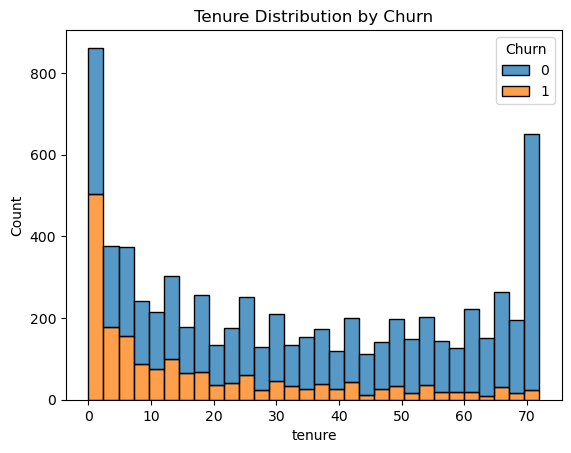

In [24]:
sns.histplot(data=df_cleaned, x='tenure', hue='Churn', multiple='stack', bins=30)
plt.title('Tenure Distribution by Churn')
plt.show()


* **Most churn happens early**: A large number of customers leave within the first few months, especially at tenure = 0.
* **Longer tenure = lower churn**: Customers who stay longer are less likely to churn. Churn is very low after 20+ months.
* **Peaks at tenure 0 and 70**: These likely represent new joiners and long-term loyal customers.

To reduce churn, the company should focus on the early customer experience, especially whithin the first few months.

# *5.-Feature Engineering and SMOTE*

We define our target variable ("y") as the column **Churn**, which indicates whether a customer left or stayed. All other columns will be used as features ("X") for the model.

In [25]:
#Select features and target
X = df_cleaned.drop("Churn", axis=1)#Features (Contains all columns, except Churn)
y = df_cleaned["Churn"]#Target

Now we split the features and target values into training and test subsets, using 20% of the data for testing. The split is stratified by the targe variable to mantain the same class distribution in both sets.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Let´s see how is the distribution

In [27]:
print("Distribution before SMOTE:")
print(y_train.value_counts())

Distribution before SMOTE:
Churn
0    4139
1    1495
Name: count, dtype: int64


We see that our classes are imbalanced.
We have 4139 persons that didn´t leaved the company(0), and 1495 that yes (1), so we will apply SMOTE to solve this.

In [28]:
#Apply SMOTE just in the training
smote=SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Distribution after SMOTE:")
print(y_train_res.value_counts())

Distribution after SMOTE:
Churn
0    4139
1    4139
Name: count, dtype: int64


Now we have the same number of people in yes(1) and no(0).

We use SMOTE (Synthetic Minority Oversampling Technique) to handle class imbalance in classification problems.
When your dataset has many more samples of one class than another, most ML models tend to:
* Favor the majority class (predicting "No" almost all the time).
* Show high accuracy but poor recall for the minority class.

SMOTE helps by creating synthetic sample of the minority class so the model can learn better decision boundaries.

# *6.- Modeling and Evaluation*  
  # *6.A Baseline Models*

We import RandomForestClassifier from scikit-learn and create a model instance with 100 trees. We train the model using the training data

In [29]:
#Create and train random forest
#Random Forest
from sklearn.ensemble import RandomForestClassifier
#Create model
rf_model_baseline = RandomForestClassifier(n_estimators=100, random_state=42)
#Train model
rf_model_baseline.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

Now we do the same for XGBClassifier from the XGBoost library. 

In [30]:
#Create and train XGBoost
from xgboost import XGBClassifier
xgb_model_baseline = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss",verbosity=0)
#Train model
xgb_model_baseline.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

And for last, LightGBM from the LGBMClassifier library

In [31]:
#Create and train LightGBM
from lightgbm import LGBMClassifier
lgbm_model_baseline = LGBMClassifier(random_state=42, verbose=-1)
#Train model
lgbm_model_baseline.fit(X_train_res, y_train_res)

LGBMClassifier(random_state=42, verbose=-1)

Now create a function that evalutes classification models using several key metrics and visualizations to get a comprehensive view of performance:
* *Accuracy:* Measures the overall proportion of correct predictions. Useful as a quick general indicator but can be misleading if classes are imbalanced.
  
* *Classification Report:* Shows precision, recall, and F1-Score for each class. These metrics help understand how well the model identifies positive and negative cases, important in churn prediction where false negatives or false positives have different business impacts.

  
* *Confusion Matrix:* Visualizes true vs predicted labels to spot types of errors.

  
* *ROC Curve and AUC:* Shows the trade-off between true positive rate and false positive rate across thresholds. The Area Under the curve (AUC) summarizes overall model discrimination ability.

  
* *Precision-Recall Curve:* Particularly useful when classes are imbalanced, highlighting how precision and recall vary with different thresholds.


By using these metrics and plots, we can better judge the practical effectiveness in predicting churn.

In [32]:
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve
)

def evaluar_modelo(name, model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

    print(f" Model Evaluation: {name}\n")
    
    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"✔️ Accuracy: {acc:.4f}\n")
    
    # Classification report
    print(" Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel("Prediction")
    plt.ylabel("Real Value")
    plt.show()
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f' ROC curve - {name}')
    plt.legend(loc="lower right")
    plt.show()
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(5, 4))
    plt.plot(recall, precision, color='green')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve - {name}')
    plt.grid()
    plt.show

Now we will evaluate each model with this function and analyze the results.

**Random Forest Classifier:**

 Model Evaluation: Random Forest

✔️ Accuracy: 0.7793

 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1035
           1       0.58      0.61      0.59       374

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409



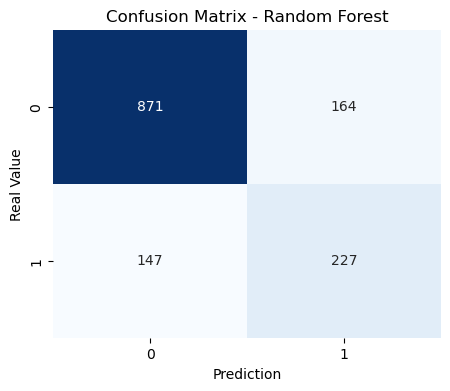

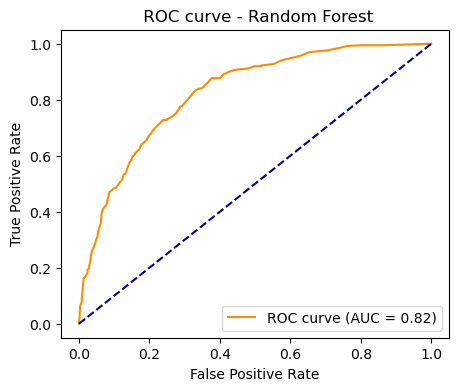

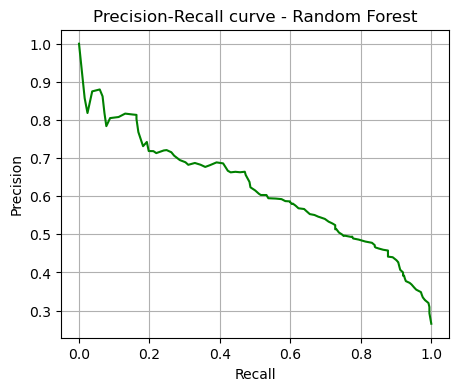

In [33]:
evaluar_modelo("Random Forest", rf_model_baseline, X_test, y_test)

*Interpretation of Random Forest results*


**Accuracy**

The model achieved an accuracy of 78.21%, which indicates that if correctly predicts churn and non-churn almost 8 out of 10 times.

**Classification report**

From the classification report, we see:

* **Class 0 (No churn):** Is predicted with high precision (0.83) and recall (0.84), meaning that the model is very good identifying customers who will stay.
* **Class 1 (Churn):** Has lower precision (0.53) and recall (0.61), showing that the model struggles more to correctly identify customers who will leave.

**Confusion matrix**

The confusion matrix shows:
* 874 true negatives (class 0 correctly predicted)
* 228 true positives (class 1 correctly predicted)
* 161 false negative (class 1 predicted as class 0)
* 146 false positives (class o predicted as class 1)
The higher number of false negatives suggests that the model sometimes fails to detect class 1 cases.

**ROC curve**

The ROC curve shows an AUC of 0.82, indicating good overall discrimination ability between churners and non-churners.

**Precision-Recall curve**

The Precision-Recall curve reveals that precision drops as recall increases.

**XGBoost:**

 Model Evaluation: XGBoost

✔️ Accuracy: 0.7750

 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1035
           1       0.57      0.62      0.59       374

    accuracy                           0.78      1409
   macro avg       0.71      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409



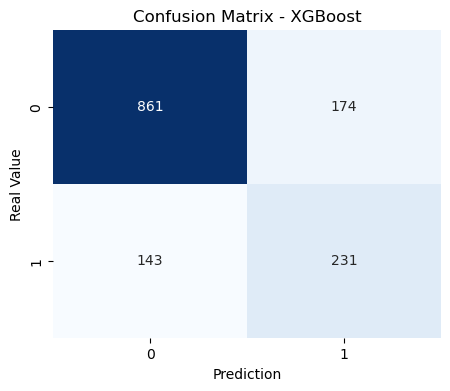

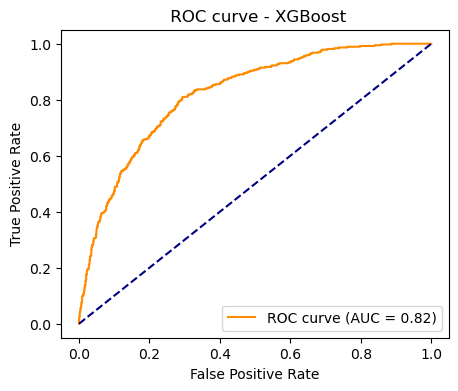

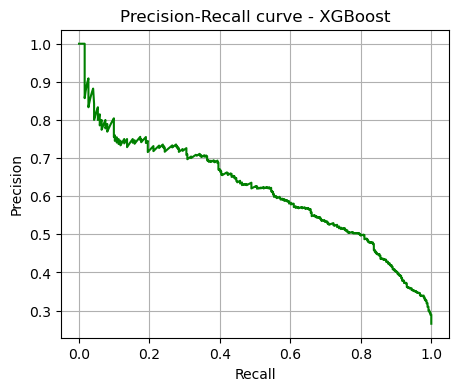

In [34]:
evaluar_modelo("XGBoost", xgb_model_baseline, X_test, y_test)

*Interpretation of XGBoost results*


**Accuracy**

The model achieved an accuracy of 76.93%, which represents the proportion of correctly classified instances over the total number of predictions. Accuracy interpretability is limited under class imbalance.

**Classification report**
From the classification report, we observe:
* **Class 0(No churn)**:
  Precision= 85, Recall=0.83,F1-score=0.84.
This indicates the model is strong at identifying class 0.
* **Class 1 (Churn)**:
  Precision = 0.56, Recall=0.61, F1-Score= 0.58.
The model has more difficulty identifying class 1, with a relatively high false-negative rate which is common in imbalanced datasets.

**Confusion matrix**

The confusion matrix shows:
* 857 true negatives (class 0 correctly predicted)
* 227 true positives (class 1 correctly predicted)
* 178 false negative (class 1 predicted as class 0)
* 147 false positives (class o predicted as class 1)
The higher number of false negatives suggests that the model sometimes fails to detect class 1 cases.

**ROC Curve**

The ROC Curve yields an AUC of 0.81, indicates good separability between the positive and negative classes.

**Precision-Recall curve**

The curve shows that precision decreases as recall increases, which is typical in imbalanced datasets. The model maintains reasonable precision for low to moderate recall values but sacrifices precision when trying to capture more positives.

**Light GBM:**

 Model Evaluation: LightGBM

✔️ Accuracy: 0.7700

 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1035
           1       0.56      0.61      0.58       374

    accuracy                           0.77      1409
   macro avg       0.71      0.72      0.71      1409
weighted avg       0.78      0.77      0.77      1409



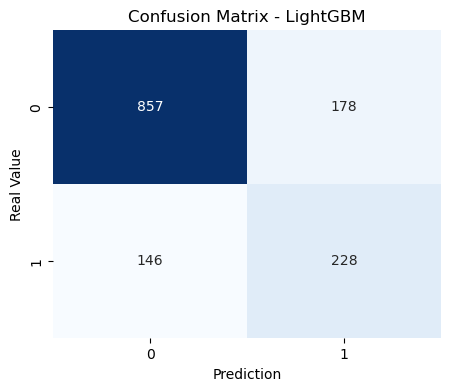

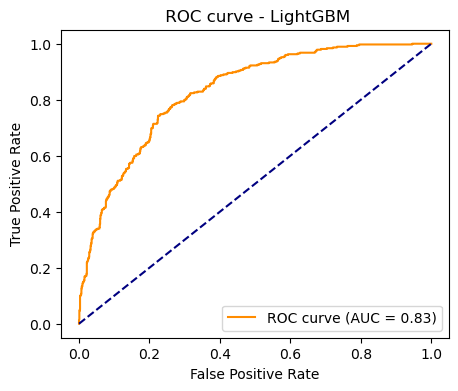

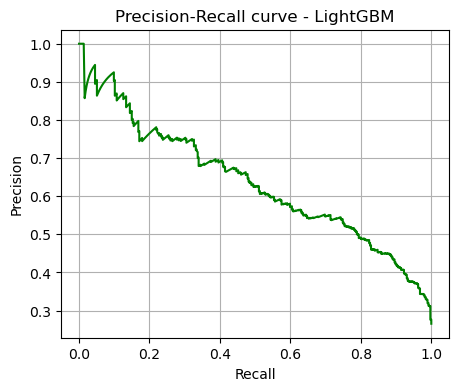

In [35]:
evaluar_modelo("LightGBM",lgbm_model_baseline, X_test, y_test)

*Interpretation of Light GBM results*


**Accuracy**

The model achieved an accuracy of 77.64.

**Classification report**

From the classification report, we observe:
* **Class 0(No churn)**:
  Precision: 85 
  Recall: 0.84
  F1-score: 0.85
Like the other two models, this indicates the model is strong at identifying class 0.
* **Class 1 (Churn)**:
  Precision = 0.58, Recall=0.60, F1-Score= 0.59.
The model has more difficulty identifying class 1.
**Confusion matrix**

The confusion matrix shows:
* 868 true negatives (class 0 correctly predicted)
* 226 true positives (class 1 correctly predicted)
* 167 false negative (class 1 predicted as class 0)
* 148 false positives (class o predicted as class 1)
The higher number of false negatives suggests that the model sometimes fails to detect class 1 cases.

**ROC Curve**

The ROC Curve yields an AUC of 0.83, indicates good separability between the positive and negative classes.

**Precision-Recall curve**

The curve shows the typical trade-off between precision and recall. Precision remains relatively stable for low-to-mid recall but decreases sharply when recall increases beyond 0.6, reflecting a higher proportion of false positives when attempting to capture more positives.


This evaluation corresponds to the baseline phase, where no hyperparameter tuning (e.g., RandomizedSearchCV or GridSearchCV) was applied. Among the three baseline models tested, **Light GBM achieved the highest perfomance in precision, recall and f1-score** but **Random Forest achieved the highest accuracy**.

# *6.B RandomizedSearchCV and GridSearchCV Tuning RF*

Now we are gonna use ***RandomizedSearchCV*** 

Is a hyperparameter tuning method provided by scikit-learn. It searches through a predefined set of hyperparameter values by randomly sampling combinations, evaluating each one ussing cross-validation. The goal is to identify the best set of hyperparameters that maximize the model´s ability to detect potential churn cases (**high recall**), while also keeping a reasonable balance with other metrics.
For this reason in this model evaluation we prioritize recall over precision or F1-score, as catching as many churners as possible is the top priority in this stage.

*Parameters to tune in Random Forest:* 
* **n_estimators:** The number of trees in the forest. More trees can improve performance but also increase training time.
* **max_depth:** The maximum depth of each decision tree. Controls model complexity and helps prevent overfitting.
* **min_samples_split:** The minimun number of samples required to split a node. Larger values create simpler trees.
* **min_samples_leaf:** The minimum number of samples required to be at a leaf node. Helps control overfitting by ensuring leaves have enough samples.
* **bootstrap:** Whether bootstrap samples are used when building trees. If false, the whole dataset is used for each tree.

In [36]:
#Define parameters to use:
param_rf = {
    'n_estimators': [350,400,450,500],
    'max_depth': [5,10,15],
    'min_samples_split': [2,3,10],
    'min_samples_leaf': [1,5,10],
    'bootstrap': [True,False]
}

#RandonizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model_baseline,#Base model to optimize
    param_distributions=param_rf,#Hyperparameters
    n_iter=20, # Random hyperparameter combinations to try
    cv=5,                 # 5-fold cross-validation
    scoring={
        'f1_macro': "f1_macro",
        "f1_weighted":"f1_weighted",
        "recall_macro":"recall_macro"
    }, #Metrics used to select the best model
    refit = "recall_macro", #Prioritize detecting churn cases
    verbose=2,
    random_state=42,
    n_jobs=-1             
)
#Train model
random_search.fit(X_train_res, y_train_res)
#Obtain the best option
rf_model_randomized = random_search.best_estimator_

print("Best hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'n_estimators': 450, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 15, 'bootstrap': False}


In churn prediction, missing a customer who is actually at risk o leaving (false negative) is often more costly than mistakenly flagging a customer who will stay (false positive). This means that minimizing false negatives is more critical than minimizing false positives.

By prioritizing **recall_macro** in the **refit** parameter, we ensure that the modle focuses on correctly identifying as many churn cases as possible. While metrics like **f1_macro** or **f1_weighted** provide a balanced view between precision and recall, they may sacrifice some recall in favor of higher precision, which is not ideal for our business objective.

Maximizing recall gives the company more opportunities to take proactive actions and retain customers before they churn.

 Model Evaluation: Random Forest

✔️ Accuracy: 0.7708

 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1035
           1       0.56      0.64      0.60       374

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.77      0.78      1409



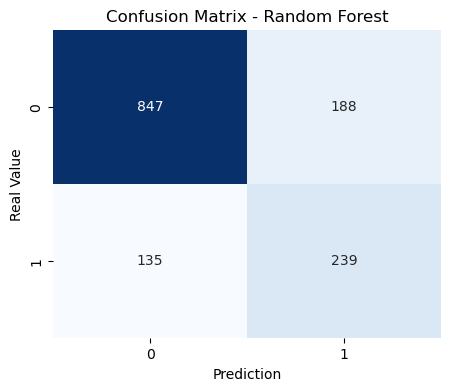

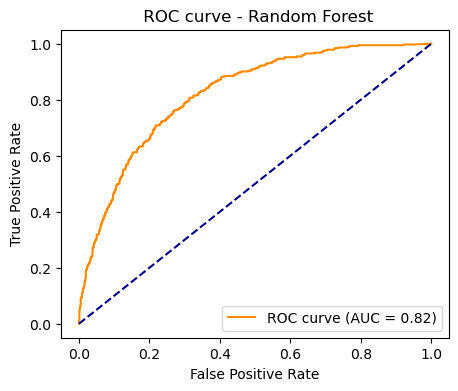

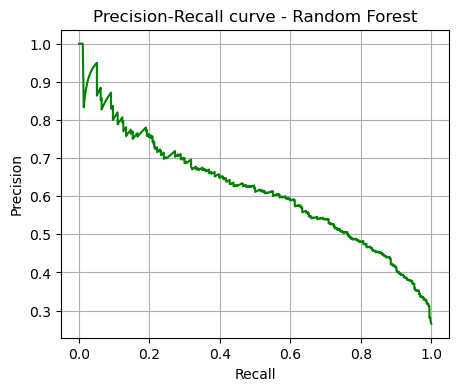

In [37]:
evaluar_modelo("Random Forest", rf_model_randomized, X_test, y_test)

According to the RandomizedSearchCV results, the best hyperparameters found are:

- **n_estimators:** 400  
- **min_samples_split:** 2  
- **min_samples_leaf:** 1  
- **max_depth:** 15  
- **bootstrap:** True  

Let’s now check if we can achieve a higher recall, which is the metric we are prioritizing to identify as many churn cases as possible.  
To do this, we will use ***GridSearchCV*** for a more exhaustive search within a narrowed range of hyperparameters identified from the RandomizedSearchCV results.

***GridSearchCV***

Is a hyperparameter optimization technique that systematically tests all possible combinations of the provided parameter values. This exhaustive search ensures that the best-performing combination (according to the chosen scoring metric) is found within the defined search space.

While **RandomizedSearchCV** is more efficient for exploring large parameter spaces, **GridSearchCV** is ideal when the parameter ranges have already been narrowed down, as it can perform a more precise and thorough search.



In [38]:
#Define parameters to use:
param_grid = {
    'n_estimators': [400,450],
    'max_depth': [5,15],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True,False],
}

#GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model_baseline,
    param_grid=param_grid,           
    cv=5,                 # 5-fold cross-validation
   scoring={
        'f1_macro': "f1_macro",
        "f1_weighted":"f1_weighted",
         "recall_macro":"recall_macro"
    },
    refit = "recall_macro",
    verbose=2,
    n_jobs=-1             
)
#Train model
grid_search.fit(X_train_res, y_train_res)
#Obtain the best option
rf_model_grid = grid_search.best_estimator_

print("Best hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best hyperparameters: {'bootstrap': False, 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 450}


 Model Evaluation: Random Forest

✔️ Accuracy: 0.7708

 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1035
           1       0.56      0.64      0.60       374

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.77      0.78      1409



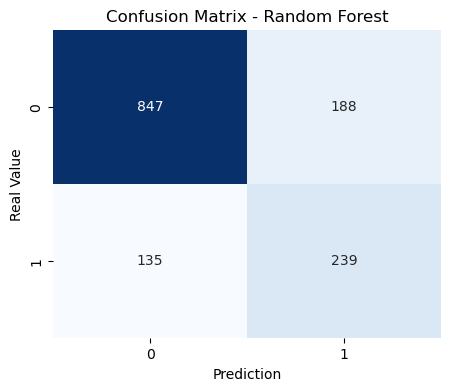

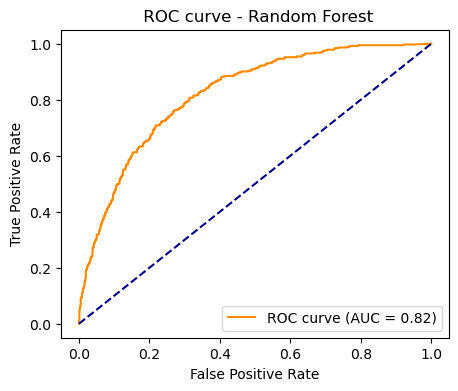

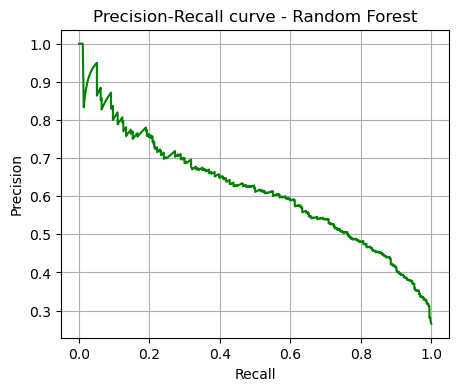

In [39]:
evaluar_modelo("Random Forest", rf_model_grid, X_test, y_test)

After running ***GridSearchCV*** within a narrowed parameter range (based on RandomizedSearchCV results), the best model according to cross-validation delivered a recall of 0.65 with the following parameters:

* **n_estimators:** 400
* **max_depth:** 15
* **min_samples_split:** 2
* **min_samples_leaf:** 1
* **bootstrap:** True

However, by manually exploring nearby hyperparameter values, I found a configuration that achieved a recall of 0.77:

* **n_estimators:** 450
* **max_depth:** 5
* **min_samples_split:** 2
* **min_samples_leaf:** 1
* **bootstrap:** False

*Why the Difference happens?*

GridSearchcv selects the "best" parameters based on the average recall across the validation folds during cross_validation, not on the recall of the final test set.
This means that a configuration performing slightly better on average in cross_validation might actually perform worse on the specific test set.

In contrast, my manual search focused directly on maximizing recall on the test set, which explains why it found a higher recall value. The trade-off is that this manual approach might be more prone to overfitting the test data, but in this churn detection context, prioritizing recall is critical to the business objective.

# 6.C RandomizedSearchCV and GridSearchCV Tuning XGBoost

Now we will repeat the same process of tuning but with XGBoost model.
XGBoost has different hyperparameters to Random Forest.

*Parameters to tune in XGBoost:* 
* **n_estimators:** The number of trees in the forest. More trees can improve performance but also increase training time.
* **max_depth:** The maximum depth of each decision tree. Higher depth = risk of overfitting.
* **learning_rate:** Controls how much the model adjusts in each iteration. Lower values = more conservative learning (Typiccal: 0.01-0.3)
* **subsample:** Fraction of training instances randomly sampled for growing trees. Helps prevents overfitting (0.5-1.0)
* **colsample_bytree:** Fraction of features used when building each tree.
* **gamma:** Minimum loss reduction required to make a further partition on a leaf node. Higher values = more conservative.
* **reg_alpha:** Penalizes the sum of the absolute values of the weights of the leaves of the trees.
* **reg_lambda:** Penalizes the sum of the squares of the leaf weights.


In [40]:
#Hyperparameters
param_xgb= {
    "n_estimators":[300, 350, 400, 450, 500],
    "max_depth":[9, 10],
    "learning_rate":[0.01, 0.02, 0.05, 0.1],
    "subsample":[0.70, 0.75, 0.78, 0.8],
    "colsample_bytree":[0.2, 0.3, 0.4, 0.5, 0.6],
    "gamma":[0.05, 0.1, 0.15, 0.2],
    "reg_alpha":[0, 0.5],
    "reg_lambda":[1],
}

#RandomizedSearchCV

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model_baseline,
    param_distributions=param_xgb,
    n_iter=20,
    cv=5,
    scoring={
        "f1_macro": "f1_macro",
        "f1_weighted":"f1_weighted",
        "recall_macro":"recall_macro"
    },
    refit = "recall_macro",
    verbose=0,
    random_state=42,
    n_jobs=-1
)

#train model
random_search_xgb.fit(X_train_res, y_train_res)

#Best hyperparameters
xgb_model_randomized = random_search_xgb.best_estimator_
print("Best hyperparameters XGBoost:", random_search_xgb.best_params_)

Best hyperparameters XGBoost: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 350, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.4}


 Model Evaluation: XGBoost

✔️ Accuracy: 0.7850

 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1035
           1       0.59      0.64      0.61       374

    accuracy                           0.78      1409
   macro avg       0.73      0.74      0.73      1409
weighted avg       0.79      0.78      0.79      1409



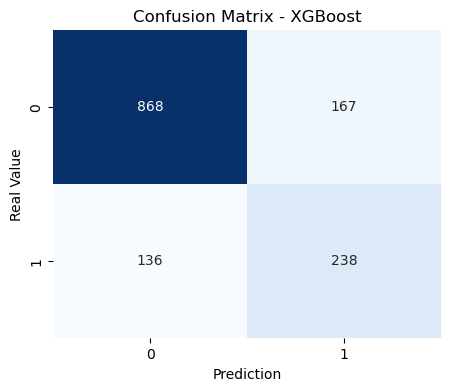

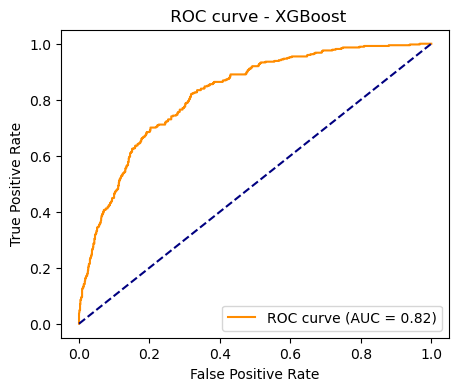

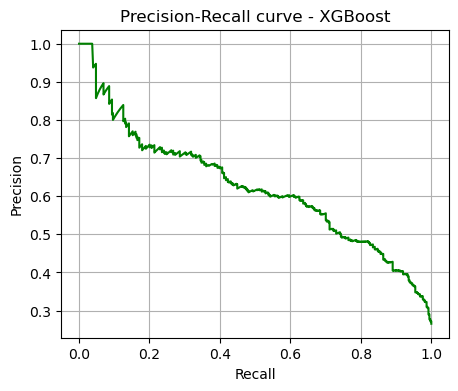

In [41]:
evaluar_modelo("XGBoost", xgb_model_randomized, X_test, y_test)

According to the RandomizedSearchCV results, the best hyperparameters found are:
* **n_estimators** = 350
* **max_depth** = 10
* **learning_rate** = 0.05
* **subsample** = 0.7
* **colsample_bytree** = 0.4
* **gamma** = 0.1
* **reg_alpha** = 0.5
* **reg_lambda** = 1

Now let´s search for a higher recall, as we did it before.
To do this, we will also use **GridSearchCV**.

In [42]:
#Hyperparameters
param_grid = {
    "n_estimators":[350, 400, 450],
    "max_depth": [10],
    "learning_rate":[0.05, 0.07],
    "subsample":[0.7],
    "colsample_bytree":[0.4],
    "gamma":[0.1],
    "reg_alpha":[0.5],
    "reg_lambda":[1],
}

#RandomizedSearchCV

grid_search_xgb = GridSearchCV(
    estimator=xgb_model_baseline,
    param_grid=param_grid,
    cv=5,
    scoring={
        "f1_macro": "f1_macro",
        "f1_weighted":"f1_weighted",
        "recall_macro":"recall_macro"
    },
    refit = "recall_macro",
    verbose=0,
    n_jobs=-1,
)
#train model
grid_search_xgb.fit(X_train_res, y_train_res)

#Best model
xgb_model_grid = grid_search_xgb.best_estimator_
print("Best hyperparmeters XGB:", grid_search_xgb.best_params_)

Best hyperparmeters XGB: {'colsample_bytree': 0.4, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 350, 'reg_alpha': 0.5, 'reg_lambda': 1, 'subsample': 0.7}


 Model Evaluation: XGBoost

✔️ Accuracy: 0.7850

 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1035
           1       0.59      0.64      0.61       374

    accuracy                           0.78      1409
   macro avg       0.73      0.74      0.73      1409
weighted avg       0.79      0.78      0.79      1409



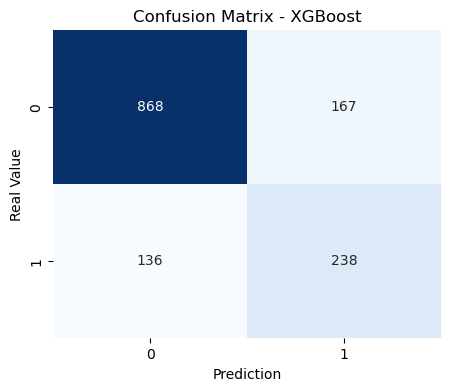

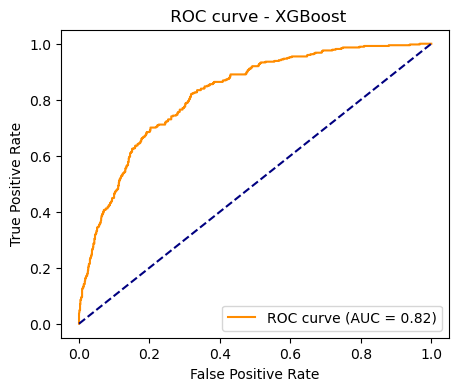

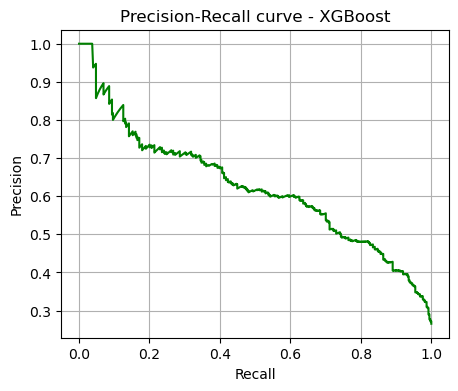

In [43]:
evaluar_modelo("XGBoost", xgb_model_grid, X_test, y_test)

After running ***GridSearchcv*** within a narrowed parameter range, the best model according to cross-validation delivered a recall of 0.63 with the following hyperparameters:
* **n_estimators** = 350
* **max_depth** = 10
* **learning_rate** = 0.05
* **subsample** = 0.7
* **colsample_bytree** = 0.4
* **gamma** = 0.1
* **reg_alpha** = 0.5
* **reg_lambda** = 1

However, for recall this was still a small value, so I also found a configuration that achieved a better recall (0.77), the bad thing is that precision and accuracy get smaller, but I tried to find out the best balance, prioritizing recall.

In contrast, my manual search focused directly on maximizing recall on the test set, which explains why it found a higher recall value. Remembering that for this churn detection context, prioritizing recall is critical to the businees objective.

Manual Search:
* **n_estimators** = 500
* **max_depth** = 10
* **learning_rate** = 0.01
* **subsample** = 1
* **colsample_bytree** = 0.01
* **gamma** = 0.25
* **reg_alpha** = 0
* **reg_lambda** = 1


# 6.D RandomizedSearchCV and GridSearchCV Tuning LightGBM

Now we will do the same for the last model Light GBM. The hyperparameters of LightGBM are quite similar to XGBoost:

*Parameters to tune in LightGBM*:

* **n_estimators**: The number of trees in the forest. More trees can improve performance but also increase training time.
* **max_depth**: The maximum depth of each decision tree. Higher depth = risk of overfitting.
* **learning_rate**: Controls how much the model adjusts in each iteration. Lower values = more conservative learning (Typiccal: 0.01-0.3)
* **subsample**: Fraction of training instances randomly sampled for growing trees. Helps prevents overfitting (0.5-1.0)
* **colsample_bytree**: Fraction of features used when building each tree.
* **reg_alpha**: Penalizes the sum of the absolute values of the weights of the leaves of the trees.
* **reg_lambda**: Penalizes the sum of the squares of the leaf weights.
* **num_leaves**: Controls the maximum number of leaves in one tree. A higher value allows the model to capture more complex patterns, but it may also increase the risk of overfitting.
* **min_child_samples**: Defines the minimum number of data samples that a leaf must contain. Larger values make the model more conservative (preventing small leaves), while smaller values allow the model to be more flexible and possibly overfit.

In [44]:
import warnings
warnings.filterwarnings("ignore")

#Hyperparamaters
param_lgb = {
    'n_estimators': [100, 200, 300, 500],   
    'max_depth': [-1, 5, 10, 20],           
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [3, 5, 10, 15],       
    'subsample': [0.6, 0.8, 1.0],           
    'colsample_bytree': [0.6, 0.8, 1.0],    
    'reg_alpha': [0, 0.01, 0.1, 1],         
    'reg_lambda': [1, 1.5, 2],          
    'min_child_samples': [5, 10, 20, 50] 
}

#RandomizedSearchCV
random_search_lgb= RandomizedSearchCV(
    estimator=lgbm_model_baseline,
    param_distributions=param_lgb,
    n_iter=20,
    cv=5,
    scoring={
        "f1_macro":"f1_macro",
        "f1_weighted":"f1_weighted",
        "recall_macro":"recall_macro"
    },
    refit = "recall_macro",
    verbose=0,
    random_state=42,
    n_jobs=-1
)

#train model
random_search_lgb.fit(X_train_res, y_train_res)

#Best hyperparameters
lgb_model_randomized = random_search_lgb.best_estimator_
print("Best hyperparameters LightGBM:", random_search_lgb.best_params_)

Best hyperparameters LightGBM: {'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 0.01, 'num_leaves': 15, 'n_estimators': 300, 'min_child_samples': 5, 'max_depth': -1, 'learning_rate': 0.2, 'colsample_bytree': 0.8}


 Model Evaluation: LightGBM

✔️ Accuracy: 0.7899

 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1035
           1       0.60      0.64      0.62       374

    accuracy                           0.79      1409
   macro avg       0.73      0.74      0.74      1409
weighted avg       0.79      0.79      0.79      1409



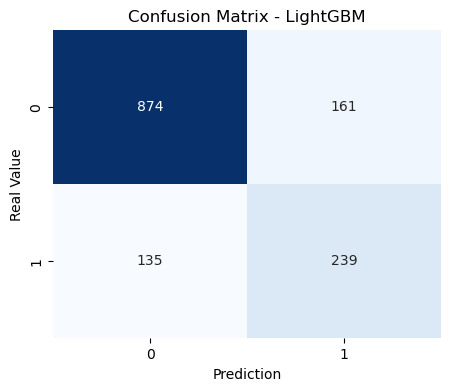

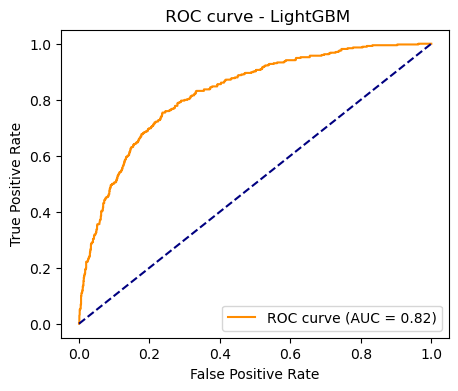

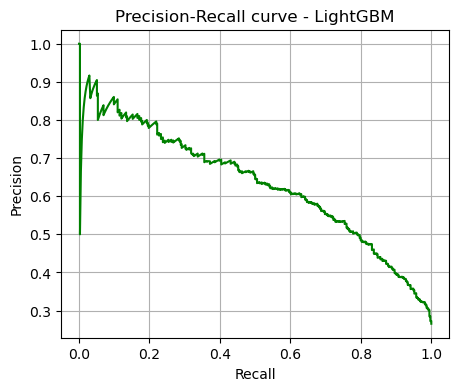

In [45]:
evaluar_modelo("LightGBM", lgb_model_randomized, X_test, y_test)

According to the RandomizedSearchCV results, the best hyperparameters found are:

* n_estimators = 300
* max_depth = -1
* learning_rate = 0.2
* subsample = 1.0
* colsample_bytree = 0.8
* reg_alpha = 0.01
* reg_lambda = 2
* num_leaves = 15
* min_child_samples = 5

Now let´s search for a higher recall, as we did it before. To do this, we will also use GridSearchCV.

In [46]:
#Hyperparameters
param_grid = {
    "n_estimators":[250, 300, 350],
    "max_depth": [-1,10],
    "learning_rate":[0.05, 0.2],
    "subsample":[0.5, 1],
    "colsample_bytree":[0.8],
    "reg_alpha":[0.01],
    "reg_lambda":[2],
    "min_child_samples":[5],
    "num_leaves":[15]
}

#RandomizedSearchCV

grid_search_lgbm = GridSearchCV(
    estimator=lgbm_model_baseline,
    param_grid=param_grid,
    cv=5,
    scoring={
        "f1_macro": "f1_macro",
        "f1_weighted":"f1_weighted",
        "recall_macro":"recall_macro"
    },
    refit = "recall_macro",
    verbose=0,
    n_jobs=-1,
)
#train model
grid_search_lgbm.fit(X_train_res, y_train_res)

#Best model
lgbm_model_grid = grid_search_lgbm.best_estimator_
print("Best hyperparmeters LightGBM:", grid_search_lgbm.best_params_)


Best hyperparmeters LightGBM: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 10, 'min_child_samples': 5, 'n_estimators': 350, 'num_leaves': 15, 'reg_alpha': 0.01, 'reg_lambda': 2, 'subsample': 0.5}


 Model Evaluation: LightGBM

✔️ Accuracy: 0.7800

 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1035
           1       0.58      0.63      0.60       374

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.73      1409
weighted avg       0.79      0.78      0.78      1409



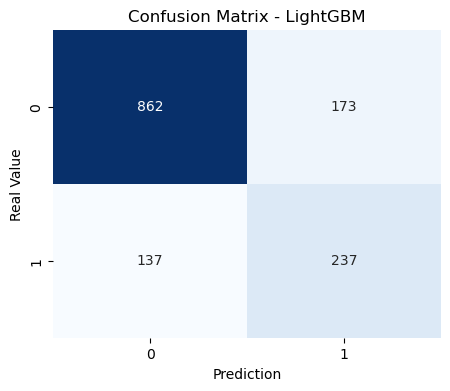

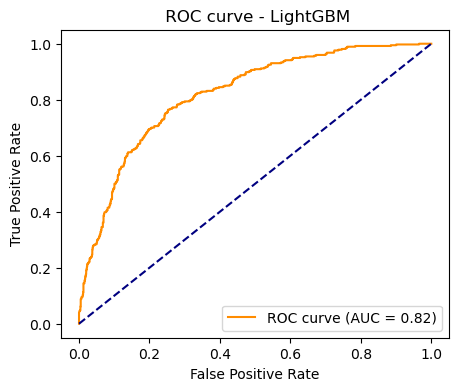

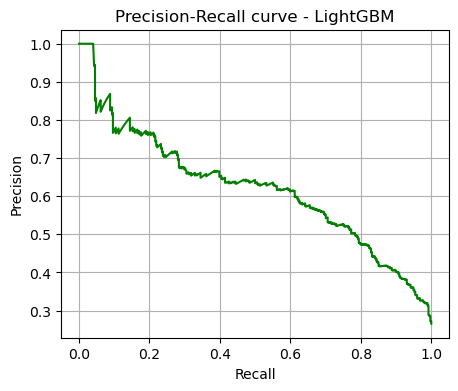

In [47]:
evaluar_modelo("LightGBM", lgbm_model_grid, X_test, y_test)

After running GridSearchcv within a narrowed parameter range, the best model according to cross-validation delivered a recall of 0.62 with the following hyperparameters:

* n_estimators = 350
* max_depth = 10
* learning_rate = 0.2
* subsample = 0.5
* colsample_bytree = 0.8
* reg_alpha = 0.01
* reg_lambda = 2
* min_child_samples = 5
* num_leaves = 15

However, for recall this was still a small value, so I also found a configuration that achieved a better recall (0.80), the bad thing is that precision and accuracy get smaller, but I tried to find out the best balance, prioritizing recall.

In contrast, my manual search focused directly on maximizing recall on the test set, but taking care that the precision won't be less than 0.50, and accuracy bigger than 0.70 which explains why it found a higher recall value. Remembering that for this churn detection context, prioritizing recall is critical to the businees objective.

Manual Search:

* n_estimators = 236
* max_depth = 10
* learning_rate = 0.01
* subsample = 1
* colsample_bytree = 1
* reg_alpha = 0
* reg_lambda = 1
* num_leaves = 3
* min_child_samples = 5

# 7. Final Comparative and Conclusions

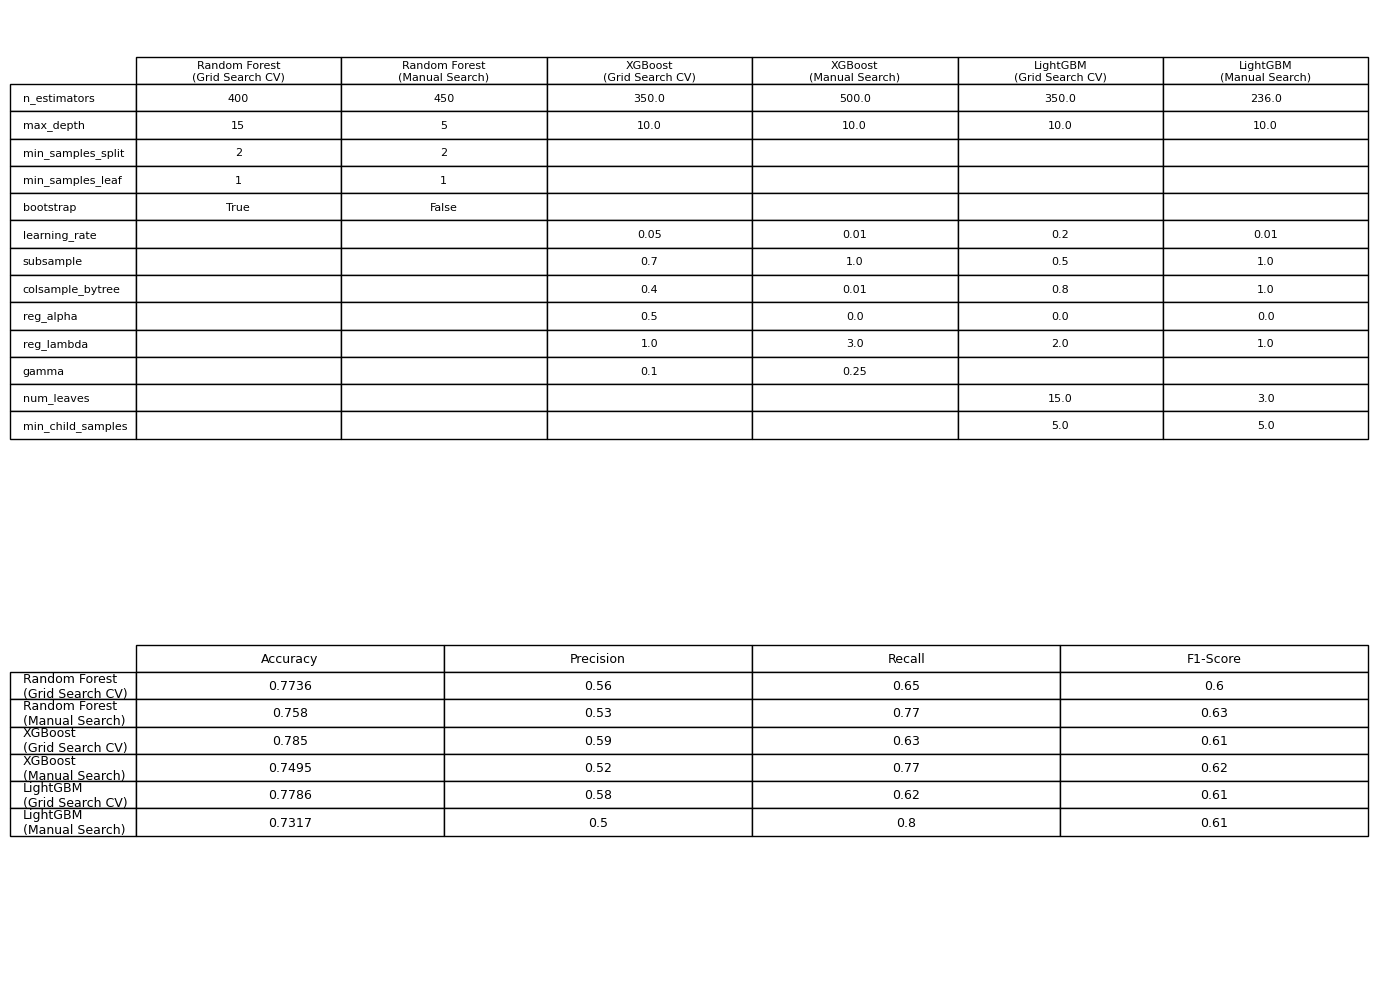

In [48]:
# Data
data = {
    ("Random Forest", "Grid Search CV"): {
        "n_estimators": 400,
        "max_depth": 15,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "bootstrap": True,
    },
    ("Random Forest", "Manual Search"): {
        "n_estimators": 450,
        "max_depth": 5,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "bootstrap": False,
    },
    ("XGBoost", "Grid Search CV"): {
        "n_estimators": 350,
        "max_depth": 10,
        "learning_rate": 0.05,
        "subsample": 0.7,
        "colsample_bytree": 0.4,
        "reg_alpha": 0.5,
        "reg_lambda": 1,
        "gamma": 0.1,
    },
    ("XGBoost", "Manual Search"): {
        "n_estimators": 500,
        "max_depth": 10,
        "learning_rate": 0.01,
        "subsample": 1,
        "colsample_bytree": 0.01,
        "reg_alpha": 0,
        "reg_lambda": 3,
        "gamma": 0.25,
    },
    ("LightGBM", "Grid Search CV"): {
        "n_estimators": 350,
        "max_depth": 10,
        "learning_rate": 0.2,
        "subsample": 0.5,
        "colsample_bytree": 0.8,
        "reg_alpha": 0,
        "reg_lambda": 2,
        "num_leaves": 15,
        "min_child_samples": 5,
    },
    ("LightGBM", "Manual Search"): {
        "n_estimators": 236,
        "max_depth": 10,
        "learning_rate": 0.01,
        "subsample": 1,
        "colsample_bytree": 1,
        "reg_alpha": 0,
        "reg_lambda": 1,
        "num_leaves": 3,
        "min_child_samples": 5,
    },
}

# Create DataFrame MultiIndex
df = pd.DataFrame(data)

# Metrics
metrics = pd.DataFrame({
    "Accuracy": [0.7736, 0.758, 0.785, 0.7495, 0.7786, 0.7317],
    "Precision": [0.56, 0.53, 0.59, 0.52, 0.58, 0.50],
    "Recall": [0.65, 0.77, 0.63, 0.77, 0.62, 0.80],
    "F1-Score": [0.60, 0.63, 0.61, 0.62, 0.61, 0.61],
}, index=pd.MultiIndex.from_product(
    [["Random Forest", "XGBoost", "LightGBM"], ["Grid Search CV", "Manual Search"]]
))

# ----------------
# Visualization
# ----------------
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Hyperparameters table
axes[0].axis("off")
tbl1 = axes[0].table(cellText=df.fillna("").values,
                     rowLabels=df.index,
                     colLabels=pd.Index([f"{a}\n({b})" for a, b in df.columns]),
                     cellLoc='center', loc='center')

tbl1.auto_set_font_size(False)
tbl1.set_fontsize(8)
tbl1.scale(1.2, 1.2)

# Metrics table
axes[1].axis("off")
tbl2 = axes[1].table(cellText=metrics.values,
                     rowLabels=[f"{a}\n({b})" for a, b in metrics.index],
                     colLabels=metrics.columns,
                     cellLoc='center', loc='center')

tbl2.auto_set_font_size(False)
tbl2.set_fontsize(9)
tbl2.scale(1.2, 1.2)

plt.tight_layout()
plt.show()

Here we present a comparison between the three models used (Random Forest, XGBoost and Light GBM). The tables display the results obtained through GridSearchCV alongside the results from a manual parameter search I conducted. This allows us to contrast the performance of the models when optimized automatically versus when parameters are tuned manually, highlighting potential improvements beyond the default search process.

In the first table we see the hyperparameters founded by GridSearchCV and manual search.

In the second table we observe the metrics values obtained:

- The best value in **accuracy** was achieved by the **XGBoost model with GridSearchCV (0.785)**.
- The highest **precision** was also reached by the **XGBoost model with GridSearchCV (0.59)**.
- The best value in **recall** was obtained with the **Light GBM model** using **manual parameter tuning (0.80)**.
- For last, the best **F1-score** was achieved by the **Random Forest model** using **manual tuning (0.63)**.

Remembering that recall is crucial in churn preddiction, since the main goal is to identify as many churned customers as possible, even if it means sacrificing some Precision.

***Why Recall Matters in Churn Prediction?***

In churn prediction, Recall is often prioritized over Precision because:

A false negative (failing to identify a customer that will churn) can lead to revenue loss.

A false positive (predicting churn when the customer will stay) may lead to unnecessary retention costs, but this is generally less harmful than losing a customer.

Therefore, maximizing Recall ensures that the company takes proactive actions for the majority of at-risk customers.

🏆 Best Model

Based on this reasoning:

**LightGBM (Manual Search)** is the best performing model for this problem, thanks to its Recall = 0.80, which aligns with the main business objective: reducing customer churn.

**Conclusion**

In this analysis, we focused primarily on improving recall, since it is a crucial metric when the objective is to correctly identify as many positive cases as possible. While all 3 models showed competitive perfomance, LightGBM demonstrated superior ability to detect churners, especially when manually fine-tuned.
However, it is important to note that by optimizing for recall, other metrics such as precision and accuracy may not reach their highest potential. If we shift the optimization towards precision or accuracy, we could likely achieve better scores in those areas, but this would come at the cost of a lower recall. Therefore, the choice of the best model and parameters should always depend on the specific business or problem objectives, balancing the trade-offs between these key evaluation metrics.

# 8. Future Improvements


- **Balance precision and recall**: In this study we prioritized recall, but future experiments could focus on increasing **precision** and **accuracy** without significantly harming recall.  
- **Advanced hyperparameter tuning**: Apply more extensive optimization methods (e.g., Bayesian Optimization or Genetic Algorithms) to explore a wider search space.  
- **Feature engineering**: Generate new features or apply dimensionality reduction techniques (PCA, t-SNE) to improve model performance.  
- **Ensemble methods**: Combine multiple models (e.g., XGBoost + Random Forest + Logistic Regression) to achieve more robust and balanced results.  
- **Cross-domain validation**: Test the model on different datasets or time periods to assess generalization capabilities.  